In [1]:
#Importing audio file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#Import plotting
import matplotlib.pyplot as plt
import seaborn as sb

#For managing sound
import librosa
import soundfile as sf

# Misc.
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000)

### Recursively get files

In [2]:
def file_fetch(src,audio_paths,file=None):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(file!=None):
                if(file in l[i]):
                    audio_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    audio_fetch(str(src+"/"+l[i]+"/"),audio_paths)
                except:
                    continue
            else:
                if(".wav" in l[i] or ".mp3" in l[i] or ".aac" in l[i]):
                    audio_paths.append(str(src+l[i]))
                            

In [3]:
audio_files=[]
text_files=[]
file_fetch("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/",audio_files)
file_fetch("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/",text_files,".txt")
audio_files.sort()
text_files.sort()

df=pd.DataFrame(columns=["Audio","Text"])

diagnosis=pd.read_csv("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None)

df["Audio"]=audio_files
df["Text"]=text_files

target=[]
for i in range(len(df)):
    target.append(diagnosis[diagnosis[0]==int(df.iloc[i][0].split("/")[-1].split("_")[0])][1].values[0])

df["target"]=target

In [4]:
df.head(5)

,Audio,Text,target
0,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt,URTI
1,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt,URTI
2,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt,Healthy
3,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt,Asthma
4,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_Litt3200.wav,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_Litt3200.txt,COPD


In [5]:
pd.Series(df["target"]).value_counts()

target
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

In [6]:
df = df[(df["target"] != "Asthma") & (df["target"] != "LRTI")]
pd.Series(df["target"]).value_counts()

target
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
Name: count, dtype: int64

In [7]:
ds=df[["Audio","Text"]].values

train_x,test_x,train_y,test_y=train_test_split(ds,df["target"].values,test_size=0.25)

timings=[]
for i in ds:
    wv,sr=librosa.load(i[0])
    time=len(wv)/sr
    timings.append(time)

In [8]:
len(train_x),len(train_y),len(test_x),len(test_y)

(687, 687, 230, 230)

<Axes: >

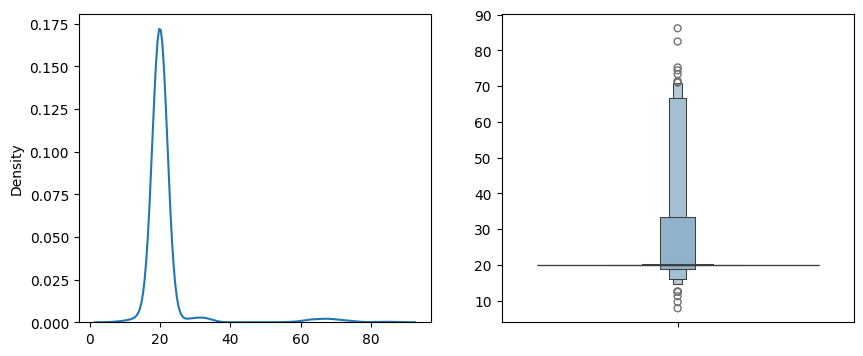

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sb.kdeplot(timings)
plt.subplot(1,2,2)
sb.boxenplot(timings)

In [10]:
complete_data_train=pd.DataFrame(columns=["audio_path",'start','end','crackles','weezels',"target"])
complete_data_test=pd.DataFrame(columns=["audio_path",'start','end','crackles','weezels',"target"])
test=[]
def make_dataframe(complete_data: pd.DataFrame(), ds: list, target: list):
    for i in range(len(ds)):
        for j in pd.read_table(ds[i][1],names=['start','end','crackles','weezels']).values:
            l1=list(j)
            l1.insert(0,ds[i][0])
            l1.append(target[i])
            complete_data=pd.concat([complete_data,pd.DataFrame(np.asarray(l1).reshape(1,-1),columns=["audio_path",'start','end','crackles','weezels',"target"]),],axis=0)
    return complete_data

complete_data_train=make_dataframe(complete_data_train,train_x,train_y)
complete_data_test=make_dataframe(complete_data_test,test_x,test_y)

complete_data_train.reset_index(inplace=True,drop=True)
complete_data_test.reset_index(inplace=True,drop=True)

In [11]:
complete_data_train["target"].value_counts()

target
COPD              4332
Healthy            235
URTI               213
Pneumonia          177
Bronchiolitis       89
Bronchiectasis      88
Name: count, dtype: int64

In [12]:
complete_data_test["target"].value_counts()

target
COPD              1414
Pneumonia          108
Healthy             87
Bronchiolitis       71
URTI                30
Bronchiectasis      16
Name: count, dtype: int64

In [13]:
assert sorted(list(complete_data_train["target"].unique())) == sorted(list(complete_data_test["target"].unique())), "Difference in targets detected for train and test set"

<Axes: ylabel='Density'>

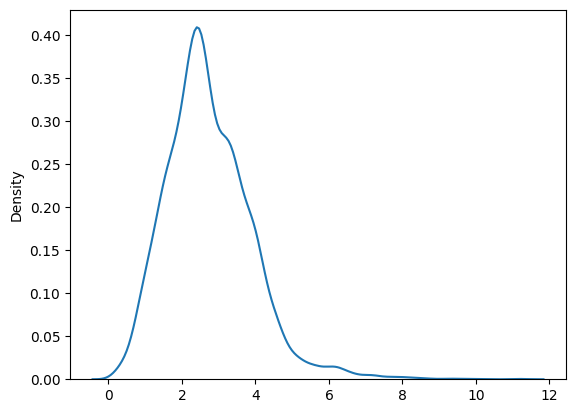

In [14]:
complete_data_train["start"]=complete_data_train["start"].astype(float)
complete_data_train["end"]=complete_data_train["end"].astype(float)
complete_data_train["length"]=complete_data_train["end"]-complete_data_train["start"]

complete_data_test["start"]=complete_data_test["start"].astype(float)
complete_data_test["end"]=complete_data_test["end"].astype(float)
complete_data_test["length"]=complete_data_test["end"]-complete_data_test["start"]

sb.kdeplot(complete_data_train["length"].values)

### We'll make the constant length as 7.5s

Anything less than this we'll pad with zeros
Anything more than this we'll trim

In [15]:
complete_data_train.head(5)

,audio_path,start,end,crackles,weezels,target,length
0,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/177_1b4_Ar_mc_AKGC417L.wav,0.359,3.364,0.0,0.0,COPD,3.005
1,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/177_1b4_Ar_mc_AKGC417L.wav,3.364,7.888,0.0,0.0,COPD,4.524
2,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/177_1b4_Ar_mc_AKGC417L.wav,7.888,11.043,0.0,0.0,COPD,3.155
3,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/177_1b4_Ar_mc_AKGC417L.wav,11.043,14.583,0.0,0.0,COPD,3.540
4,../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/177_1b4_Ar_mc_AKGC417L.wav,14.583,18.740,0.0,0.0,COPD,4.157


In [16]:
len(complete_data_train)

5134

In [17]:
len(complete_data_test)

1726

In [18]:
def transformed_audio(audio_path: str,start: int,end: int) -> None:
    wv, sr = librosa.load(audio_path)
    '''
    
    sampling rate = no. of samples/time
    
    '''
    starting_point=int(max(sr*start,0))
    ending_point=int(min(sr*end,len(wv)))

    return wv[starting_point:ending_point],sr

In [19]:
def transform_and_save(complete_filtered_data: pd.DataFrame(),path: str,type: str):
    c=0
    files_saved=[]
    files=[]
    sr_coll=[]
    samples_coll=[]
    i=0
    
    for index,row in complete_filtered_data.iterrows():
        maxLen=7.5
        start=row['start']
        end=row['end']
        audio_file_loc=row['audio_path']
    
        filename=audio_file_loc.split("/")[-1].split(".")[0]
        
        #If len > maxLen , change it to maxLen
        if end-start>maxLen:
            end=start+maxLen
        
        if index > 0:
            #check if more cycles exits for same patient if so then add i to change filename
            if complete_filtered_data.iloc[index-1]['audio_path'].split("/")[-1].split(".")[0]==filename:
                i+=1
            else:
                i=0
        filename= filename + '_' + str(i) + '.wav'
        
        save_path=path + filename
        c+=1
        
        pureSample, sr=transformed_audio(audio_file_loc,start,end)
    
        
        reqLen=7.5*sr
        data = librosa.util.pad_center(data=pureSample,size=reqLen)
    
        
        sf.write(file=save_path,data=data,samplerate=sr)
        files.append(filename)
        files_saved.append(save_path)
        sr_coll.append(sr)
        samples_coll.append(len(pureSample))
        #break
    print('Total Files Processed: ',c)

    complete_filtered_data["samples"]=samples_coll
    complete_filtered_data["sample rates"]=sr_coll
    complete_filtered_data["filename"]=files
    complete_filtered_data["file_save_path"]=files_saved

    complete_filtered_data.to_csv("../Sound_Classification/archive/processed_data_"+type+".csv",index=None)
    print(f"\nCSV File Saved\n")
    
if(not os.path.exists("../Sound_Classification/archive/processed_data_train/")):
    os.mkdir("../Sound_Classification/archive/processed_data_train/")
    print("Train folder created")

transform_and_save(complete_data_train,"../Sound_Classification/archive/processed_data_train/","train")

if(not os.path.exists("../Sound_Classification/archive/processed_data_test/")):
    os.mkdir("../Sound_Classification/archive/processed_data_test/")
    print("Test folder created")

transform_and_save(complete_data_test,"../Sound_Classification/archive/processed_data_test/","test")

Train folder created
Total Files Processed:  5134

CSV File Saved

Test folder created
Total Files Processed:  1726

CSV File Saved

